In [ ]:
import pandas as pd
import numpy as np

import copy
import pickle
from datetime import datetime

import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from xgboost import plot_importance
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor

# Parameter tunning
import optuna
from sklearn.model_selection import KFold

import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

Version: 3

Data description:
- 2056 properties
- ALL transations are from year >= 2015
- restaurant_rating in the postcode
- restaurant_hygiene  in the postcode
- restaurant_bad in the postcode
- Near or in the POI (<500 or <1000) using PropertyData: 
 + Retailers --- 'Retailers - supermarkets/hypermarkets'
 + Restaurans --- 'Restaurant/Cafe/Canteen'
 + Manufacturers --- 'Manufacturers/packers'
 + Hotels --- 'Hotel/bed & breakfast/guest house'
 + Importers --- 'Importers/Exporters'
 + Mobile --- 'Mobile caterer'
 + Pubs --- 'Pub/bar/nightclub'
 + Hospitals --- 'Hospitals/Childcare/Caring Premises'
 + Takeaway --- 'Takeaway/sandwich shop'
 + School --- 'School/college/university'
 + catering --- 'Other catering premises'
 + shops --- 'Retailers - other'

In [ ]:
def date_to_year(date_string):
    fmt = '%Y-%m-%d'
    return datetime.strptime(date_string,fmt).year

In [ ]:
Data = pd.read_csv('datasetV4.csv') 

In [ ]:
len(Data)

2303

Removing outliers

In [ ]:
Data=Data[Data['PP_price']<1.000000e+06]

In [ ]:
len(Data)

2056

Removing irrelevant attributes

In [ ]:
Data['transferYear']=Data['PP_dateoftransfer'].apply(lambda x : date_to_year(x))

In [ ]:
list(Data.columns)

['Unnamed: 0',
 'Unnamed: 0.1',
 'id',
 'PP_transactionid',
 'PP_price',
 'PP_dateoftransfer',
 'postcode',
 'PP_propertytype',
 'PP_oldnew',
 'PP_duration',
 'PP_categorytype',
 'PP_dateoftpriceransfer',
 'code',
 'Year_1_Value',
 'Year_2_Value',
 'Year_2_growth',
 'Year_3_Value',
 'Year_3_growth',
 'Year_4_Value',
 'Year_4_growth',
 'Year_5_Value',
 'Year_5_growth',
 'population',
 'crimes_last_12m',
 'crimes_per_thousand',
 'crime_rating',
 'PublicOrder',
 'Burglary',
 'Robbery',
 'PossessionOfWeapons',
 'BicycleTheft',
 'AntiSocialBehaviour',
 'Violence',
 'Theft',
 'Shoplifting',
 'OtherCrime',
 'Drugs',
 'OtherTheft',
 'VehicleCrime',
 'CriminalDamage',
 'deprivation',
 'health',
 'age0_4',
 'age5_9',
 'age10_14',
 'age15_19',
 'age20_24',
 'age25_29',
 'age30_34',
 'age35_39',
 'age40_44',
 'age45_49',
 'age50_54',
 'age60_64',
 'age70_74',
 'age75_79',
 'age80_84',
 'age85_89',
 'proportion_with_degree',
 'vehicles_per_household',
 'commute_method_foot',
 'commute_method_bicycl

Property distribution by year.

No handles with labels found to put in legend.


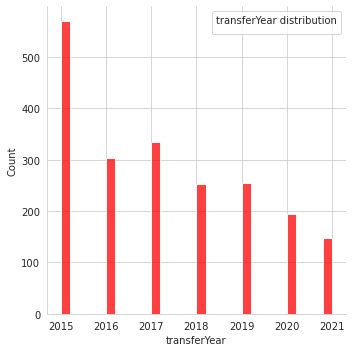

In [ ]:
sns.set_style('whitegrid')
sns.displot(Data['transferYear'], kde = False, color ='red', bins = 30)
plt.legend(title='transferYear distribution')

Property distribution on space

No handles with labels found to put in legend.


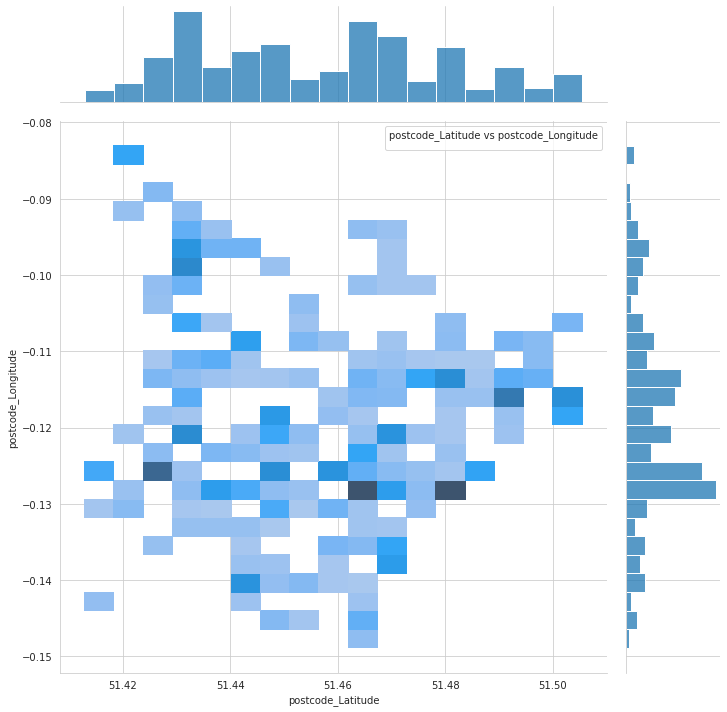

In [ ]:
sns.set_style('whitegrid')
sns.jointplot(x ='postcode_Latitude', y ='postcode_Longitude', data = Data, kind ='hist',height=10)
plt.legend(title='postcode_Latitude vs postcode_Longitude')

Property distribution by MSOA

No handles with labels found to put in legend.


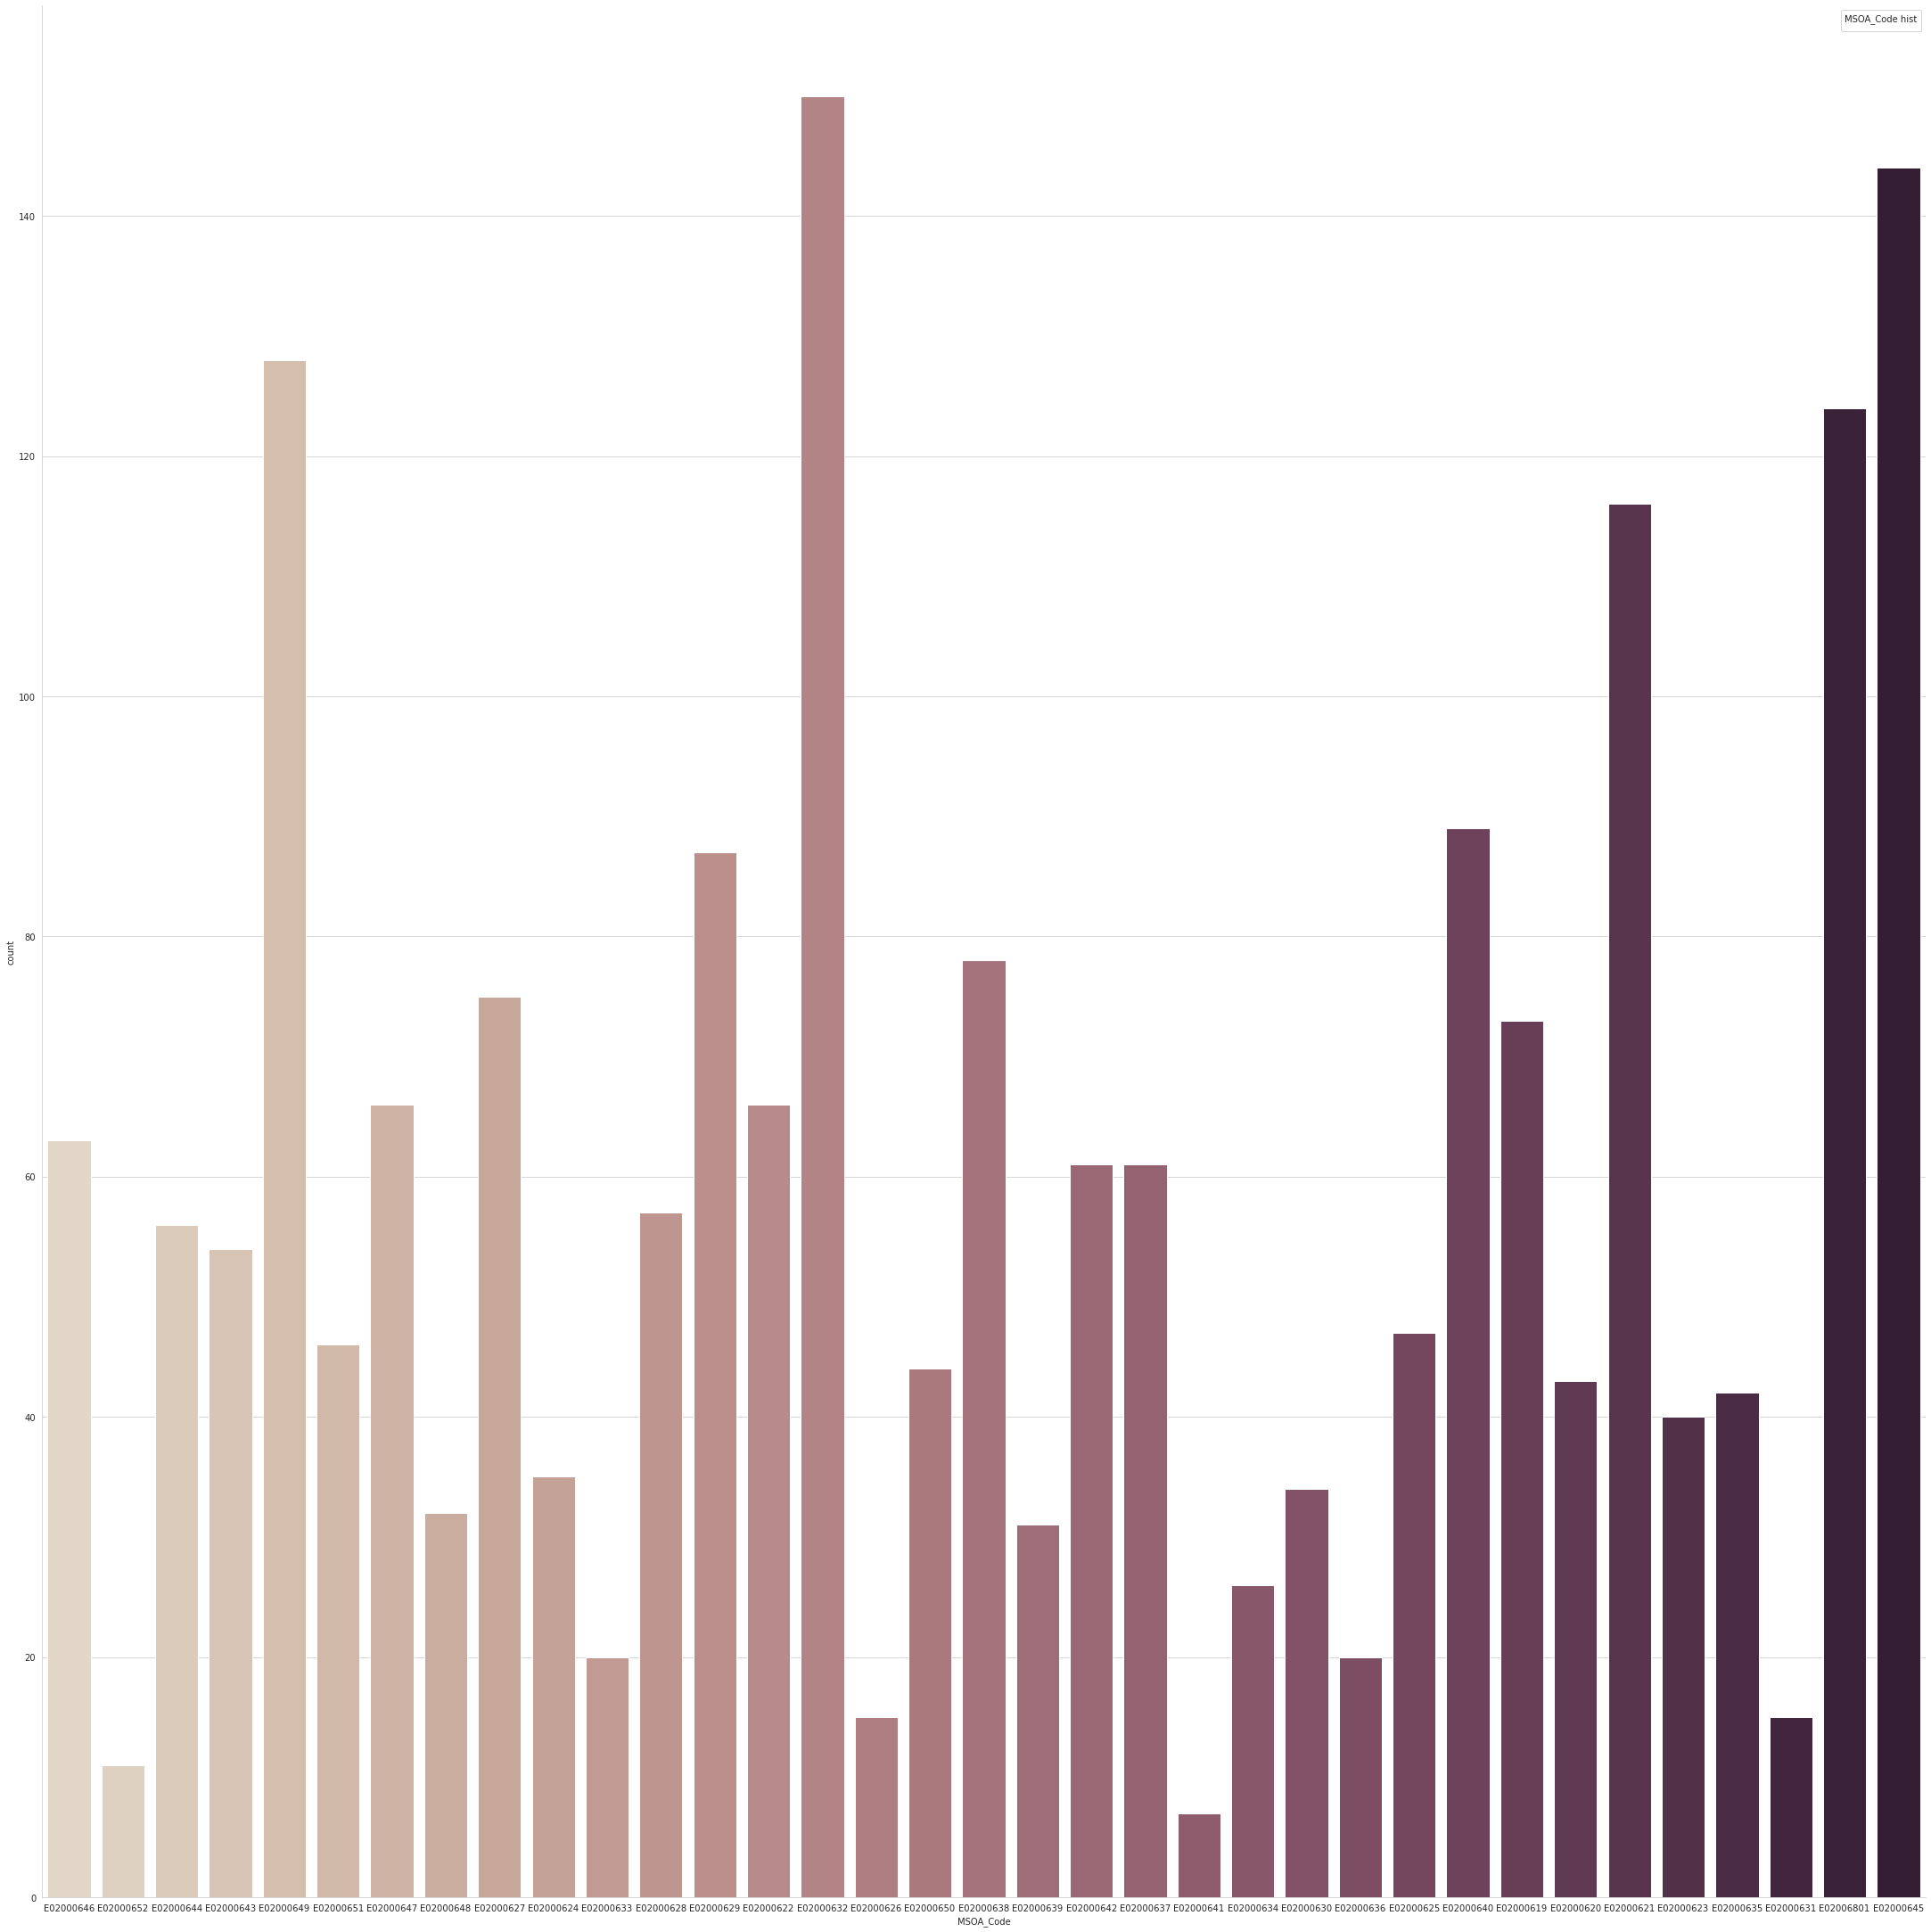

In [ ]:
sns.set_style('whitegrid')
sns.catplot(x="MSOA_Code", kind="count", palette="ch:.25", data=Data, height=30)
plt.legend(title='MSOA_Code hist')

Property distribution by code area

No handles with labels found to put in legend.


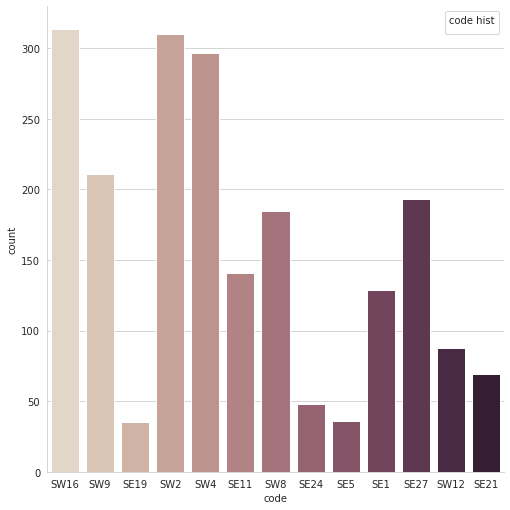

In [ ]:
sns.set_style('whitegrid')
sns.catplot(x="code", kind="count", palette="ch:.25", data=Data, height=7)
plt.legend(title='code hist')

Property price by year.

No handles with labels found to put in legend.


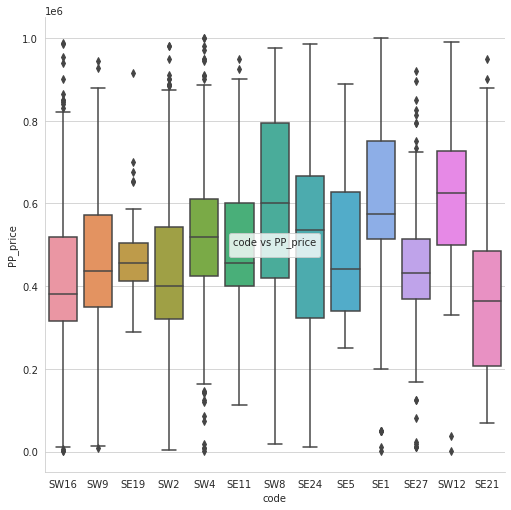

In [ ]:
sns.catplot(x="code", y="PP_price",  kind="box", data=Data,height=7)
plt.legend(title='code vs PP_price')

Crime number by area code.

No handles with labels found to put in legend.


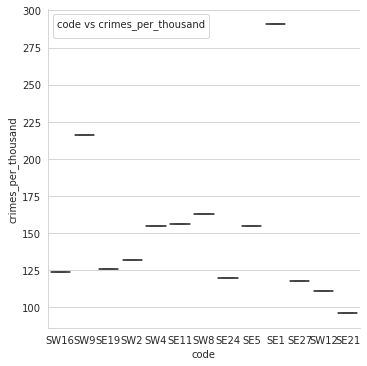

In [ ]:
sns.catplot(x="code", y="crimes_per_thousand",  kind="box", data=Data)
plt.legend(title='code vs crimes_per_thousand')

Removing inrelevant attributes

In [ ]:
dropList=['Unnamed: 0','Unnamed: 0.1','id','PP_dateoftransfer', 'PP_dateoftpriceransfer','transferYear','postcode'
         ,'postcode_Latitude','postcode_Longitude','MSOA_Code','LSOA_Code','PP_dateoftransfer','PP_transactionid',
          ]
Data.drop(dropList, axis = 1, inplace = True)

Area code Vs post code population distribution.

No handles with labels found to put in legend.


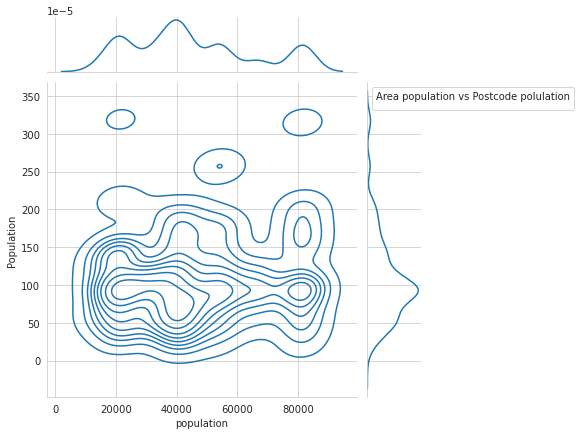

In [ ]:
sns.set_style('whitegrid')
sns.jointplot(x ='population', y ='Population', data = Data, kind ='kde')
plt.legend(title='Area population vs Postcode polulation')

Households vs Postcode population

No handles with labels found to put in legend.


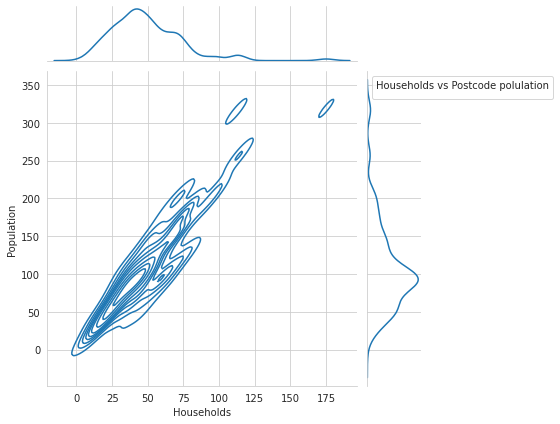

In [ ]:
sns.set_style('whitegrid')
sns.jointplot(x ='Households', y ='Population', data = Data, kind ='kde')
plt.legend(title='Households vs Postcode polulation')

### Property price statistics

In [ ]:
Data['PP_price'].describe()

count      2056.000000
mean     488907.044747
std      195108.759784
min        1000.000000
25%      360000.000000
50%      460000.000000
75%      605000.000000
max      999950.000000
Name: PP_price, dtype: float64

No handles with labels found to put in legend.


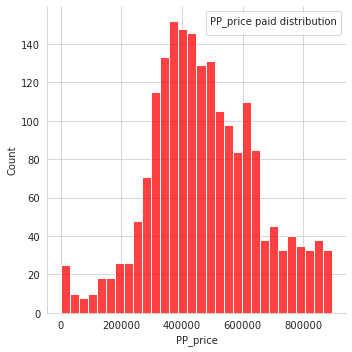

In [ ]:
sns.set_style('whitegrid')
sns.displot(Data['PP_price'], kde = False, color ='red', bins = 30)
plt.legend(title='PP_price paid distribution')

No handles with labels found to put in legend.


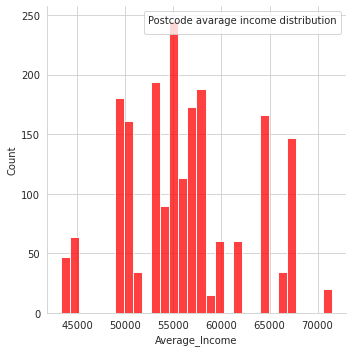

In [ ]:
sns.set_style('whitegrid')
sns.displot(Data['Average_Income'], kde = False, color ='red', bins = 30)
plt.legend(title='Postcode avarage income distribution')

No handles with labels found to put in legend.


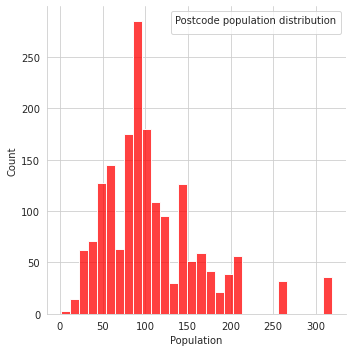

In [ ]:
sns.set_style('whitegrid')
sns.displot(Data['Population'], kde = False, color ='red', bins = 30)
plt.legend(title='Postcode population distribution')

No handles with labels found to put in legend.


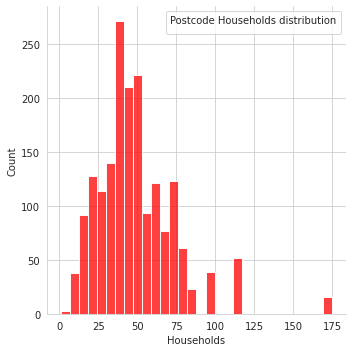

In [ ]:
sns.set_style('whitegrid')
sns.displot(Data['Households'], kde = False, color ='red', bins = 30)
plt.legend(title='Postcode Households distribution')

No handles with labels found to put in legend.


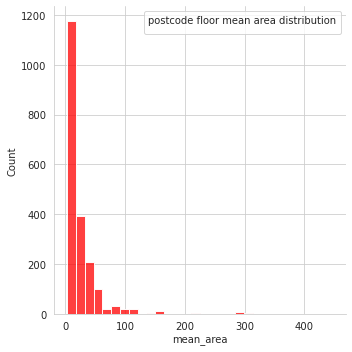

In [ ]:
sns.set_style('whitegrid')
sns.displot(Data['mean_area'], kde = False, color ='red', bins = 30)
plt.legend(title='postcode floor mean area distribution')

### Categorical attribute binarization

In [ ]:

lbl = preprocessing.LabelEncoder()

catData = ['code','PP_propertytype', 'PP_oldnew', 'PP_duration', 'PP_categorytype', 'crime_rating', 'ptal', 'flood_risk','restaurant_rating']
for att in catData:
    unique_classes = Data[att].unique()
    one_hot = pd.get_dummies(unique_classes, prefix=att,dummy_na=True, columns = [att])
    one_hot[att] = unique_classes
    Data = Data.merge(one_hot, on = [att], how='left')
    Data = Data.drop(columns = [att])
    #Data[att] = lbl.fit_transform(Data[att].astype(str))

### Define total price as target attribute 

In [ ]:
Data['price'] = Data['PP_price']
Data.drop('PP_price', axis = 1, inplace = True)

In [ ]:
# Split data
X, y = Data.iloc[:, :-1], Data.iloc[:, -1]

### Model tunning

In [ ]:
def objective(trial, X, y, kf):
    n_estimators = trial.suggest_int('n_estimators', 206, 512)
    learning_rate =trial.suggest_uniform('learning_rate', 0, 0.1) 
    #max_depth = trial.suggest_int('max_depth', 3, 10)
    min_split_loss = trial.suggest_uniform('min_split_loss', 0, 2.5)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    reg_lambda = trial.suggest_uniform('reg_lambda', 0, 10)
    reg_alpha = trial.suggest_uniform('reg_alpha', 0, 10)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1)
    subsample = trial.suggest_uniform('subsample', 0.5, 1)
    eta = trial.suggest_uniform('eta', 0, 1)
    
    model = xg.XGBRegressor(n_estimators=n_estimators,
                          #max_depth=max_depth,
                          learning_rate=learning_rate,
                          min_split_loss=min_split_loss,
                          min_child_weight=min_child_weight,
                          reg_lambda=reg_lambda,
                          reg_alpha=reg_alpha,
                          colsample_bytree=colsample_bytree,
                          subsample=subsample,
                          eta=eta,
                          objective='reg:squarederror', 
                          booster='gbtree',
                          seed=42,
                          n_jobs=3)
    
    
    test_score = []
    
    step = 0
    
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        test_score.append(MAE(y_test, y_pred)/488907.044747*100)
        
        trial.report(np.mean(test_score), step)
        
        if trial.should_prune():
            raise optuna.TrialPruned()
            
        step+=1

    return np.mean(test_score)



kf = KFold(n_splits=4, shuffle=True, random_state=42)

study = optuna.create_study(direction='minimize',
                            pruner=optuna.pruners.SuccessiveHalvingPruner())

study.optimize(lambda trial: objective(trial, X, y, kf), timeout=30*60, n_jobs=1)

study.best_params 

[I 2021-12-02 12:46:43,178] A new study created in memory with name: no-name-4538477a-fae2-4b13-b764-c8989034a018
[I 2021-12-02 12:46:49,361] Trial 0 finished with value: 17.39786026979296 and parameters: {'n_estimators': 408, 'learning_rate': 0.056933956892545205, 'min_split_loss': 2.4996704423293985, 'min_child_weight': 10, 'reg_lambda': 2.221776008833057, 'reg_alpha': 0.9172691506382002, 'colsample_bytree': 0.8279751605950092, 'subsample': 0.9376750631816313, 'eta': 0.7496332705513165}. Best is trial 0 with value: 17.39786026979296.
[I 2021-12-02 12:46:54,676] Trial 1 finished with value: 17.314470653803767 and parameters: {'n_estimators': 334, 'learning_rate': 0.03217164731203733, 'min_split_loss': 2.4646045706112933, 'min_child_weight': 8, 'reg_lambda': 1.599265108715504, 'reg_alpha': 9.23234833241516, 'colsample_bytree': 0.6825775593247874, 'subsample': 0.5767786203525903, 'eta': 0.0267018848815449}. Best is trial 1 with value: 17.314470653803767.
[I 2021-12-02 12:46:56,361] Tria

[I 2021-12-02 12:49:23,910] Trial 53 finished with value: 17.258545511587677 and parameters: {'n_estimators': 263, 'learning_rate': 0.03653032391277814, 'min_split_loss': 1.1133011606559853, 'min_child_weight': 5, 'reg_lambda': 9.569509676452228, 'reg_alpha': 1.4732045532063458, 'colsample_bytree': 0.7326904051434138, 'subsample': 0.9410596279320272, 'eta': 0.1994735399524308}. Best is trial 51 with value: 17.233607433076976.
[I 2021-12-02 12:49:25,908] Trial 54 pruned. 
[I 2021-12-02 12:49:27,805] Trial 55 pruned. 
[I 2021-12-02 12:49:29,479] Trial 56 pruned. 
[I 2021-12-02 12:49:33,417] Trial 57 finished with value: 17.303110010838303 and parameters: {'n_estimators': 272, 'learning_rate': 0.035280045831128676, 'min_split_loss': 0.9414118250046682, 'min_child_weight': 7, 'reg_lambda': 8.14814935503882, 'reg_alpha': 1.3706326696920104, 'colsample_bytree': 0.696754377304996, 'subsample': 0.8277152079589638, 'eta': 0.03858203646835279}. Best is trial 51 with value: 17.233607433076976.
[I

[I 2021-12-02 12:52:02,600] Trial 102 finished with value: 17.288886652325004 and parameters: {'n_estimators': 306, 'learning_rate': 0.03129226672241099, 'min_split_loss': 0.0008408333751863811, 'min_child_weight': 5, 'reg_lambda': 8.158558758608674, 'reg_alpha': 3.585167276116672, 'colsample_bytree': 0.8861082069772116, 'subsample': 0.9174192890482809, 'eta': 0.2508011156505945}. Best is trial 51 with value: 17.233607433076976.
[I 2021-12-02 12:52:05,138] Trial 103 pruned. 
[I 2021-12-02 12:52:07,983] Trial 104 pruned. 
[I 2021-12-02 12:52:10,593] Trial 105 pruned. 
[I 2021-12-02 12:52:15,233] Trial 106 finished with value: 17.268873649114287 and parameters: {'n_estimators': 286, 'learning_rate': 0.029408650385092674, 'min_split_loss': 0.5250450772710861, 'min_child_weight': 6, 'reg_lambda': 7.8958102776565555, 'reg_alpha': 2.32342171451118, 'colsample_bytree': 0.8468335354815808, 'subsample': 0.8936989058370686, 'eta': 0.22990251895128666}. Best is trial 51 with value: 17.23360743307

[I 2021-12-02 12:54:18,780] Trial 143 pruned. 
[I 2021-12-02 12:54:20,716] Trial 144 pruned. 
[I 2021-12-02 12:54:25,520] Trial 145 finished with value: 17.281096935208794 and parameters: {'n_estimators': 324, 'learning_rate': 0.031020973136307712, 'min_split_loss': 0.9299390266574858, 'min_child_weight': 4, 'reg_lambda': 8.669073937699316, 'reg_alpha': 1.9637028914428813, 'colsample_bytree': 0.7495260663313138, 'subsample': 0.9117367807326414, 'eta': 0.23971372025278787}. Best is trial 51 with value: 17.233607433076976.
[I 2021-12-02 12:54:27,500] Trial 146 pruned. 
[I 2021-12-02 12:54:29,115] Trial 147 pruned. 
[I 2021-12-02 12:54:31,013] Trial 148 pruned. 
[I 2021-12-02 12:54:33,498] Trial 149 pruned. 
[I 2021-12-02 12:54:36,083] Trial 150 pruned. 
[I 2021-12-02 12:54:39,479] Trial 151 finished with value: 17.274014967369016 and parameters: {'n_estimators': 272, 'learning_rate': 0.03549069829852843, 'min_split_loss': 1.1805381833101025, 'min_child_weight': 6, 'reg_lambda': 9.9147198

[I 2021-12-02 12:56:30,987] Trial 183 finished with value: 17.265840677183856 and parameters: {'n_estimators': 285, 'learning_rate': 0.03114162833269375, 'min_split_loss': 0.5416795964886574, 'min_child_weight': 6, 'reg_lambda': 9.862147938214738, 'reg_alpha': 3.169577574623371, 'colsample_bytree': 0.7752247518468827, 'subsample': 0.9217621089323232, 'eta': 0.8077644083348777}. Best is trial 182 with value: 17.207386716948236.
[I 2021-12-02 12:56:33,079] Trial 184 pruned. 
[I 2021-12-02 12:56:37,202] Trial 185 finished with value: 17.25301872058286 and parameters: {'n_estimators': 282, 'learning_rate': 0.03260322997497571, 'min_split_loss': 0.4184215404655792, 'min_child_weight': 6, 'reg_lambda': 9.977540406218374, 'reg_alpha': 3.435091849688753, 'colsample_bytree': 0.7639222740143502, 'subsample': 0.9106117261907118, 'eta': 0.8373443413236741}. Best is trial 182 with value: 17.207386716948236.
[I 2021-12-02 12:56:39,309] Trial 186 pruned. 
[I 2021-12-02 12:56:43,569] Trial 187 finishe

[I 2021-12-02 12:58:05,571] Trial 212 finished with value: 17.224068845904153 and parameters: {'n_estimators': 299, 'learning_rate': 0.025987510802695825, 'min_split_loss': 0.3697331366683987, 'min_child_weight': 6, 'reg_lambda': 9.515442301709422, 'reg_alpha': 3.8603677131253735, 'colsample_bytree': 0.760634807479135, 'subsample': 0.8789510937797356, 'eta': 0.9134965358486771}. Best is trial 182 with value: 17.207386716948236.
[I 2021-12-02 12:58:07,780] Trial 213 pruned. 
[I 2021-12-02 12:58:09,933] Trial 214 pruned. 
[I 2021-12-02 12:58:14,401] Trial 215 finished with value: 17.24695277376243 and parameters: {'n_estimators': 304, 'learning_rate': 0.025955863267885307, 'min_split_loss': 0.32345972087522185, 'min_child_weight': 6, 'reg_lambda': 9.662860772021894, 'reg_alpha': 4.651054593447094, 'colsample_bytree': 0.7493174634140939, 'subsample': 0.8820313347305623, 'eta': 0.9511379851795665}. Best is trial 182 with value: 17.207386716948236.
[I 2021-12-02 12:58:16,618] Trial 216 prun

[I 2021-12-02 12:59:48,250] Trial 240 pruned. 
[I 2021-12-02 12:59:50,658] Trial 241 pruned. 
[I 2021-12-02 12:59:55,441] Trial 242 finished with value: 17.21502532957775 and parameters: {'n_estimators': 301, 'learning_rate': 0.029031265887754742, 'min_split_loss': 0.28190812012516187, 'min_child_weight': 6, 'reg_lambda': 9.682177322123561, 'reg_alpha': 5.9028931409100815, 'colsample_bytree': 0.8061331346669544, 'subsample': 0.8449095984845739, 'eta': 0.8701336336587131}. Best is trial 182 with value: 17.207386716948236.
[I 2021-12-02 12:59:59,246] Trial 243 pruned. 
[I 2021-12-02 13:00:01,703] Trial 244 pruned. 
[I 2021-12-02 13:00:06,713] Trial 245 finished with value: 17.251753286136957 and parameters: {'n_estimators': 313, 'learning_rate': 0.02860947041551031, 'min_split_loss': 0.21580311528641247, 'min_child_weight': 6, 'reg_lambda': 9.99547935222404, 'reg_alpha': 5.398922151086673, 'colsample_bytree': 0.8052274875673516, 'subsample': 0.8457526375266979, 'eta': 0.839114404042774}.

[I 2021-12-02 13:02:09,897] Trial 287 pruned. 
[I 2021-12-02 13:02:12,200] Trial 288 pruned. 
[I 2021-12-02 13:02:16,909] Trial 289 finished with value: 17.2271007809767 and parameters: {'n_estimators': 298, 'learning_rate': 0.02719310080285951, 'min_split_loss': 0.268291424252619, 'min_child_weight': 6, 'reg_lambda': 9.992687722060307, 'reg_alpha': 5.192319050788513, 'colsample_bytree': 0.7982642098344948, 'subsample': 0.8501547964975529, 'eta': 0.8109037200974468}. Best is trial 182 with value: 17.207386716948236.
[I 2021-12-02 13:02:21,530] Trial 290 finished with value: 17.236828944901028 and parameters: {'n_estimators': 303, 'learning_rate': 0.027841726933450266, 'min_split_loss': 0.2719601055084468, 'min_child_weight': 6, 'reg_lambda': 9.988794865856194, 'reg_alpha': 5.136851894391958, 'colsample_bytree': 0.7650307636082692, 'subsample': 0.8514498005299245, 'eta': 0.7982065793917335}. Best is trial 182 with value: 17.207386716948236.
[I 2021-12-02 13:02:23,429] Trial 291 pruned. 

[I 2021-12-02 13:04:06,566] Trial 322 finished with value: 17.243693071002063 and parameters: {'n_estimators': 284, 'learning_rate': 0.027152217217162208, 'min_split_loss': 0.3025810034890938, 'min_child_weight': 6, 'reg_lambda': 9.307139956312545, 'reg_alpha': 5.131438794258599, 'colsample_bytree': 0.7952765774989524, 'subsample': 0.8868506053088342, 'eta': 0.8516238337911638}. Best is trial 182 with value: 17.207386716948236.
[I 2021-12-02 13:04:08,884] Trial 323 pruned. 
[I 2021-12-02 13:04:13,500] Trial 324 finished with value: 17.22529841606708 and parameters: {'n_estimators': 300, 'learning_rate': 0.030285505123264014, 'min_split_loss': 0.23343688216731448, 'min_child_weight': 6, 'reg_lambda': 9.994705458871831, 'reg_alpha': 6.239847552079991, 'colsample_bytree': 0.7841764351193554, 'subsample': 0.876295006520968, 'eta': 0.870329329872114}. Best is trial 182 with value: 17.207386716948236.
[I 2021-12-02 13:04:15,498] Trial 325 pruned. 
[I 2021-12-02 13:04:17,520] Trial 326 pruned

[I 2021-12-02 13:06:27,137] Trial 374 pruned. 
[I 2021-12-02 13:06:31,848] Trial 375 finished with value: 17.236169230697303 and parameters: {'n_estimators': 311, 'learning_rate': 0.026472572640756833, 'min_split_loss': 0.592772070322334, 'min_child_weight': 6, 'reg_lambda': 9.579180683054659, 'reg_alpha': 5.35479960314011, 'colsample_bytree': 0.7718461938004596, 'subsample': 0.8730048298048946, 'eta': 0.931549575891225}. Best is trial 182 with value: 17.207386716948236.
[I 2021-12-02 13:06:36,214] Trial 376 finished with value: 17.244136595882424 and parameters: {'n_estimators': 300, 'learning_rate': 0.029199918026273426, 'min_split_loss': 0.3839885951404064, 'min_child_weight': 6, 'reg_lambda': 9.818861816958027, 'reg_alpha': 4.014975078629987, 'colsample_bytree': 0.7342173991388203, 'subsample': 0.9121051566001078, 'eta': 0.8714366788531593}. Best is trial 182 with value: 17.207386716948236.
[I 2021-12-02 13:06:40,135] Trial 377 finished with value: 17.267419644759116 and parameters

[I 2021-12-02 13:08:44,569] Trial 420 pruned. 
[I 2021-12-02 13:08:49,482] Trial 421 finished with value: 17.25096165356417 and parameters: {'n_estimators': 303, 'learning_rate': 0.029515548421213986, 'min_split_loss': 0.5182875502699321, 'min_child_weight': 5, 'reg_lambda': 9.346690952363518, 'reg_alpha': 3.169285487037535, 'colsample_bytree': 0.7794280599235377, 'subsample': 0.8942090249188535, 'eta': 0.825034820676703}. Best is trial 182 with value: 17.207386716948236.
[I 2021-12-02 13:08:51,958] Trial 422 pruned. 
[I 2021-12-02 13:08:54,165] Trial 423 pruned. 
[I 2021-12-02 13:08:56,953] Trial 424 pruned. 
[I 2021-12-02 13:09:01,394] Trial 425 finished with value: 17.284192477366144 and parameters: {'n_estimators': 296, 'learning_rate': 0.03728194433316459, 'min_split_loss': 0.36831252558598526, 'min_child_weight': 6, 'reg_lambda': 9.835926542188012, 'reg_alpha': 6.226431046105349, 'colsample_bytree': 0.7784427261220596, 'subsample': 0.9132022188649509, 'eta': 0.8825051025033541}. 

[I 2021-12-02 13:10:37,115] Trial 454 finished with value: 17.232433591337404 and parameters: {'n_estimators': 261, 'learning_rate': 0.032322217137444355, 'min_split_loss': 0.2865072658285543, 'min_child_weight': 6, 'reg_lambda': 9.701501306625575, 'reg_alpha': 3.7267628371549795, 'colsample_bytree': 0.6646113046987155, 'subsample': 0.9057209233532479, 'eta': 0.8176109147212242}. Best is trial 182 with value: 17.207386716948236.
[I 2021-12-02 13:10:40,425] Trial 455 finished with value: 17.224738218131414 and parameters: {'n_estimators': 251, 'learning_rate': 0.032946131813880675, 'min_split_loss': 0.2891873752741461, 'min_child_weight': 6, 'reg_lambda': 9.602320137538422, 'reg_alpha': 3.8022142902524676, 'colsample_bytree': 0.6451947703250036, 'subsample': 0.9066232384748728, 'eta': 0.805369481205394}. Best is trial 182 with value: 17.207386716948236.
[I 2021-12-02 13:10:43,909] Trial 456 finished with value: 17.278104169251392 and parameters: {'n_estimators': 258, 'learning_rate': 0.

[I 2021-12-02 13:12:04,246] Trial 490 pruned. 
[I 2021-12-02 13:12:05,939] Trial 491 pruned. 
[I 2021-12-02 13:12:07,649] Trial 492 pruned. 
[I 2021-12-02 13:12:09,592] Trial 493 pruned. 
[I 2021-12-02 13:12:11,218] Trial 494 pruned. 
[I 2021-12-02 13:12:15,116] Trial 495 finished with value: 17.231120524228615 and parameters: {'n_estimators': 280, 'learning_rate': 0.029773390095246644, 'min_split_loss': 0.3761218378304859, 'min_child_weight': 6, 'reg_lambda': 9.522309650355336, 'reg_alpha': 3.3960875874796046, 'colsample_bytree': 0.6785295091709346, 'subsample': 0.8771010503313911, 'eta': 0.7516407481381123}. Best is trial 182 with value: 17.207386716948236.
[I 2021-12-02 13:12:16,966] Trial 496 pruned. 
[I 2021-12-02 13:12:18,879] Trial 497 pruned. 
[I 2021-12-02 13:12:20,737] Trial 498 pruned. 
[I 2021-12-02 13:12:22,599] Trial 499 pruned. 
[I 2021-12-02 13:12:26,481] Trial 500 finished with value: 17.24402495180481 and parameters: {'n_estimators': 281, 'learning_rate': 0.0317086157

[I 2021-12-02 13:13:59,587] Trial 532 pruned. 
[I 2021-12-02 13:14:03,838] Trial 533 finished with value: 17.233294234918368 and parameters: {'n_estimators': 281, 'learning_rate': 0.02747788388205385, 'min_split_loss': 0.15589801571947265, 'min_child_weight': 6, 'reg_lambda': 9.999885925267384, 'reg_alpha': 3.1979369808734526, 'colsample_bytree': 0.7661806278914919, 'subsample': 0.8716658750884297, 'eta': 0.8418873643944473}. Best is trial 182 with value: 17.207386716948236.
[I 2021-12-02 13:14:05,981] Trial 534 pruned. 
[I 2021-12-02 13:14:07,781] Trial 535 pruned. 
[I 2021-12-02 13:14:10,873] Trial 536 pruned. 
[I 2021-12-02 13:14:12,833] Trial 537 pruned. 
[I 2021-12-02 13:14:15,076] Trial 538 pruned. 
[I 2021-12-02 13:14:17,070] Trial 539 pruned. 
[I 2021-12-02 13:14:24,597] Trial 540 finished with value: 17.290264660109536 and parameters: {'n_estimators': 492, 'learning_rate': 0.026689054773007932, 'min_split_loss': 0.1851791467534175, 'min_child_weight': 6, 'reg_lambda': 9.834347

[I 2021-12-02 13:15:55,976] Trial 573 pruned. 
[I 2021-12-02 13:15:58,083] Trial 574 pruned. 
[I 2021-12-02 13:16:00,029] Trial 575 pruned. 
[I 2021-12-02 13:16:04,405] Trial 576 finished with value: 17.23946054384409 and parameters: {'n_estimators': 294, 'learning_rate': 0.029183743510824783, 'min_split_loss': 0.29771087432300253, 'min_child_weight': 6, 'reg_lambda': 9.706988143987054, 'reg_alpha': 2.7696605404284833, 'colsample_bytree': 0.750129404029191, 'subsample': 0.8822825837861895, 'eta': 0.8716652368773546}. Best is trial 182 with value: 17.207386716948236.
[I 2021-12-02 13:16:08,572] Trial 577 finished with value: 17.264319083239158 and parameters: {'n_estimators': 274, 'learning_rate': 0.03381789902607984, 'min_split_loss': 0.22806356170462397, 'min_child_weight': 6, 'reg_lambda': 9.412096996728613, 'reg_alpha': 4.128893547682475, 'colsample_bytree': 0.7977560909160858, 'subsample': 0.910269018339401, 'eta': 0.8169167384727009}. Best is trial 182 with value: 17.2073867169482

{'n_estimators': 285,
 'learning_rate': 0.031066615807107595,
 'min_split_loss': 0.4764205181347332,
 'min_child_weight': 6,
 'reg_lambda': 9.996428369514026,
 'reg_alpha': 3.1239007058484596,
 'colsample_bytree': 0.7700732875205616,
 'subsample': 0.9186473949818381,
 'eta': 0.7976172701646677}

#### Define train and test

In [ ]:
# Splitting
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                      test_size = 0.2)

Model training

In [ ]:
model = XGBRegressor(objective='reg:squarederror', 
                     n_estimators= 285,
                     learning_rate= 0.031066615807107595,
                     min_split_loss= 0.4764205181347332,
                     min_child_weight= 6,
                     reg_lambda= 9.996428369514026,
                     reg_alpha= 3.1239007058484596,
                     colsample_bytree= 0.7700732875205616,
                     subsample=   0.9186473949818381,
                     eta=0.7976172701646677)

xgb_r = model.fit(train_X, train_y)

pred = model.predict(train_X)

# MAE Computation
mae =MAE(train_y, pred)
print("Train MAE : % f" %(mae))
print("Train Mean MAE: %f" %((mae/488907.044747)*100),"%")


pred = model.predict(test_X)

# MAE Computation
mae =MAE(test_y, pred)
print("Test MAE : % f" %(mae))
print("Test Mean MAE: %f" %((mae/488907.044747)*100),"%")

Train MAE :  68095.431509
Train Mean MAE: 13.928094 %
Test MAE :  82635.971384
Test Mean MAE: 16.902185 %


Cross validation

In [ ]:
# define model
# https://machinelearningmastery.com/xgboost-for-regression/

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f) %.3f' % (scores.mean(), scores.std(), ((scores.mean()/5.919751e+05)*100)),'%' )

Mean MAE: 83210.481 (5150.406) 14.056 %


### Plot feature importance

https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7

- The Gain implies the relative contribution of the corresponding feature to the model calculated by taking each feature’s contribution for each tree in the model. 
- The Coverage metric means the relative number of observations related to this feature.
- The Weight  is the percentage representing the relative number of times a particular feature occurs in the trees of the model
- ‘Gain’ is the improvement in accuracy brought by a feature to the branches it is on. 
- ‘Coverage’ measures the relative quantity of observations concerned by a feature.”


#### Ranking by gain (uses the -loss)

In [ ]:
#Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]
#f = 'total_gain'
#xgb_r.get_booster().get_score(importance_type= f)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

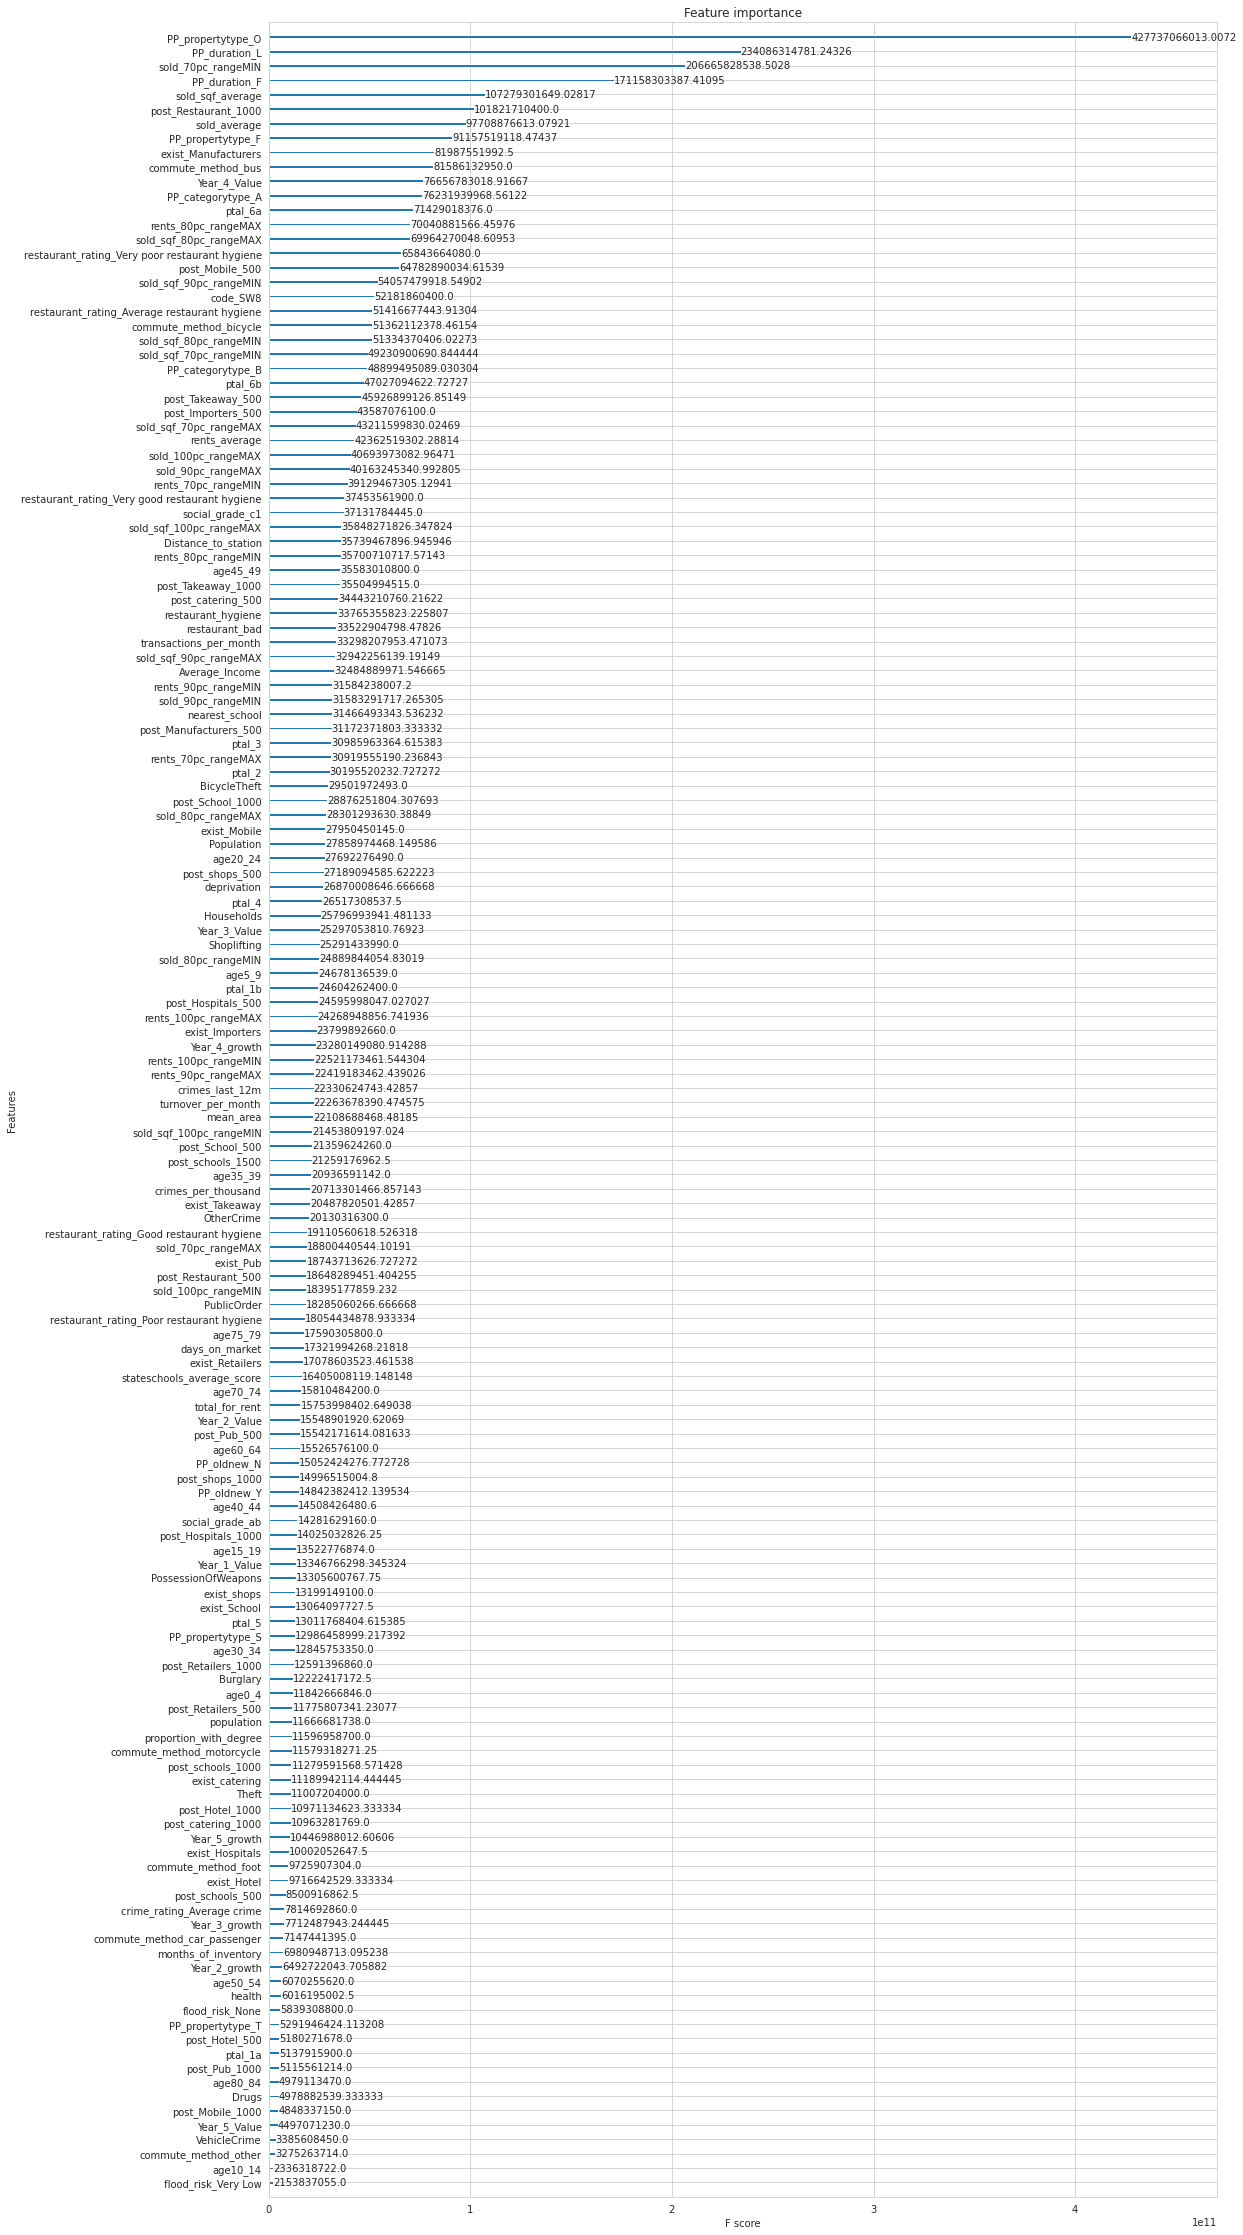

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(17,40))

xg.plot_importance(xgb_r, ax,importance_type='gain')

#### Ranking by cover

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

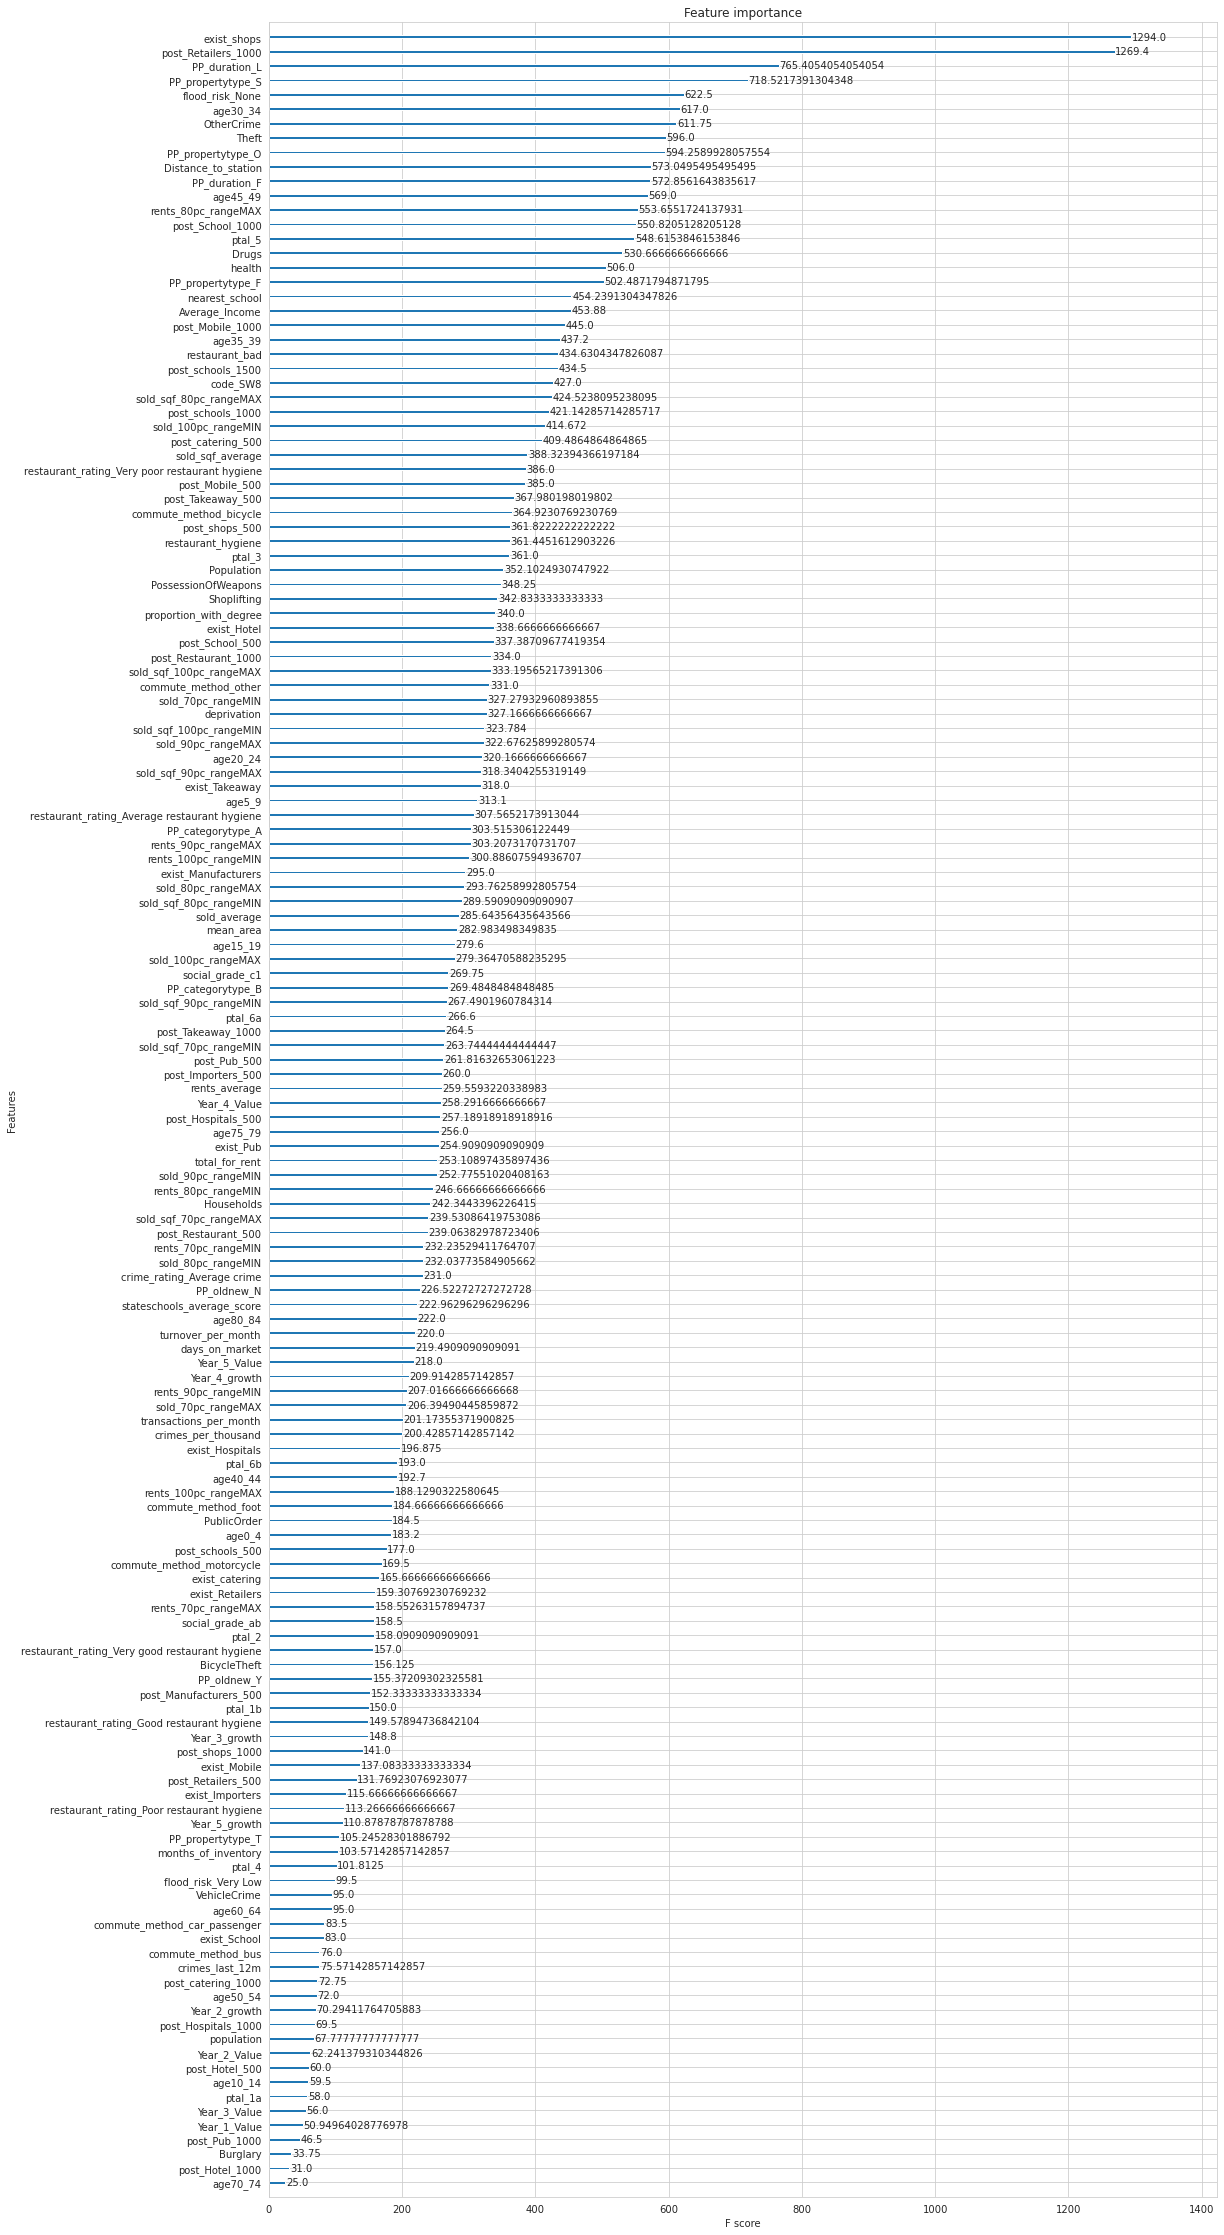

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(17,40))

xg.plot_importance(xgb_r, ax,importance_type='cover')

#### Ranking by total gain

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

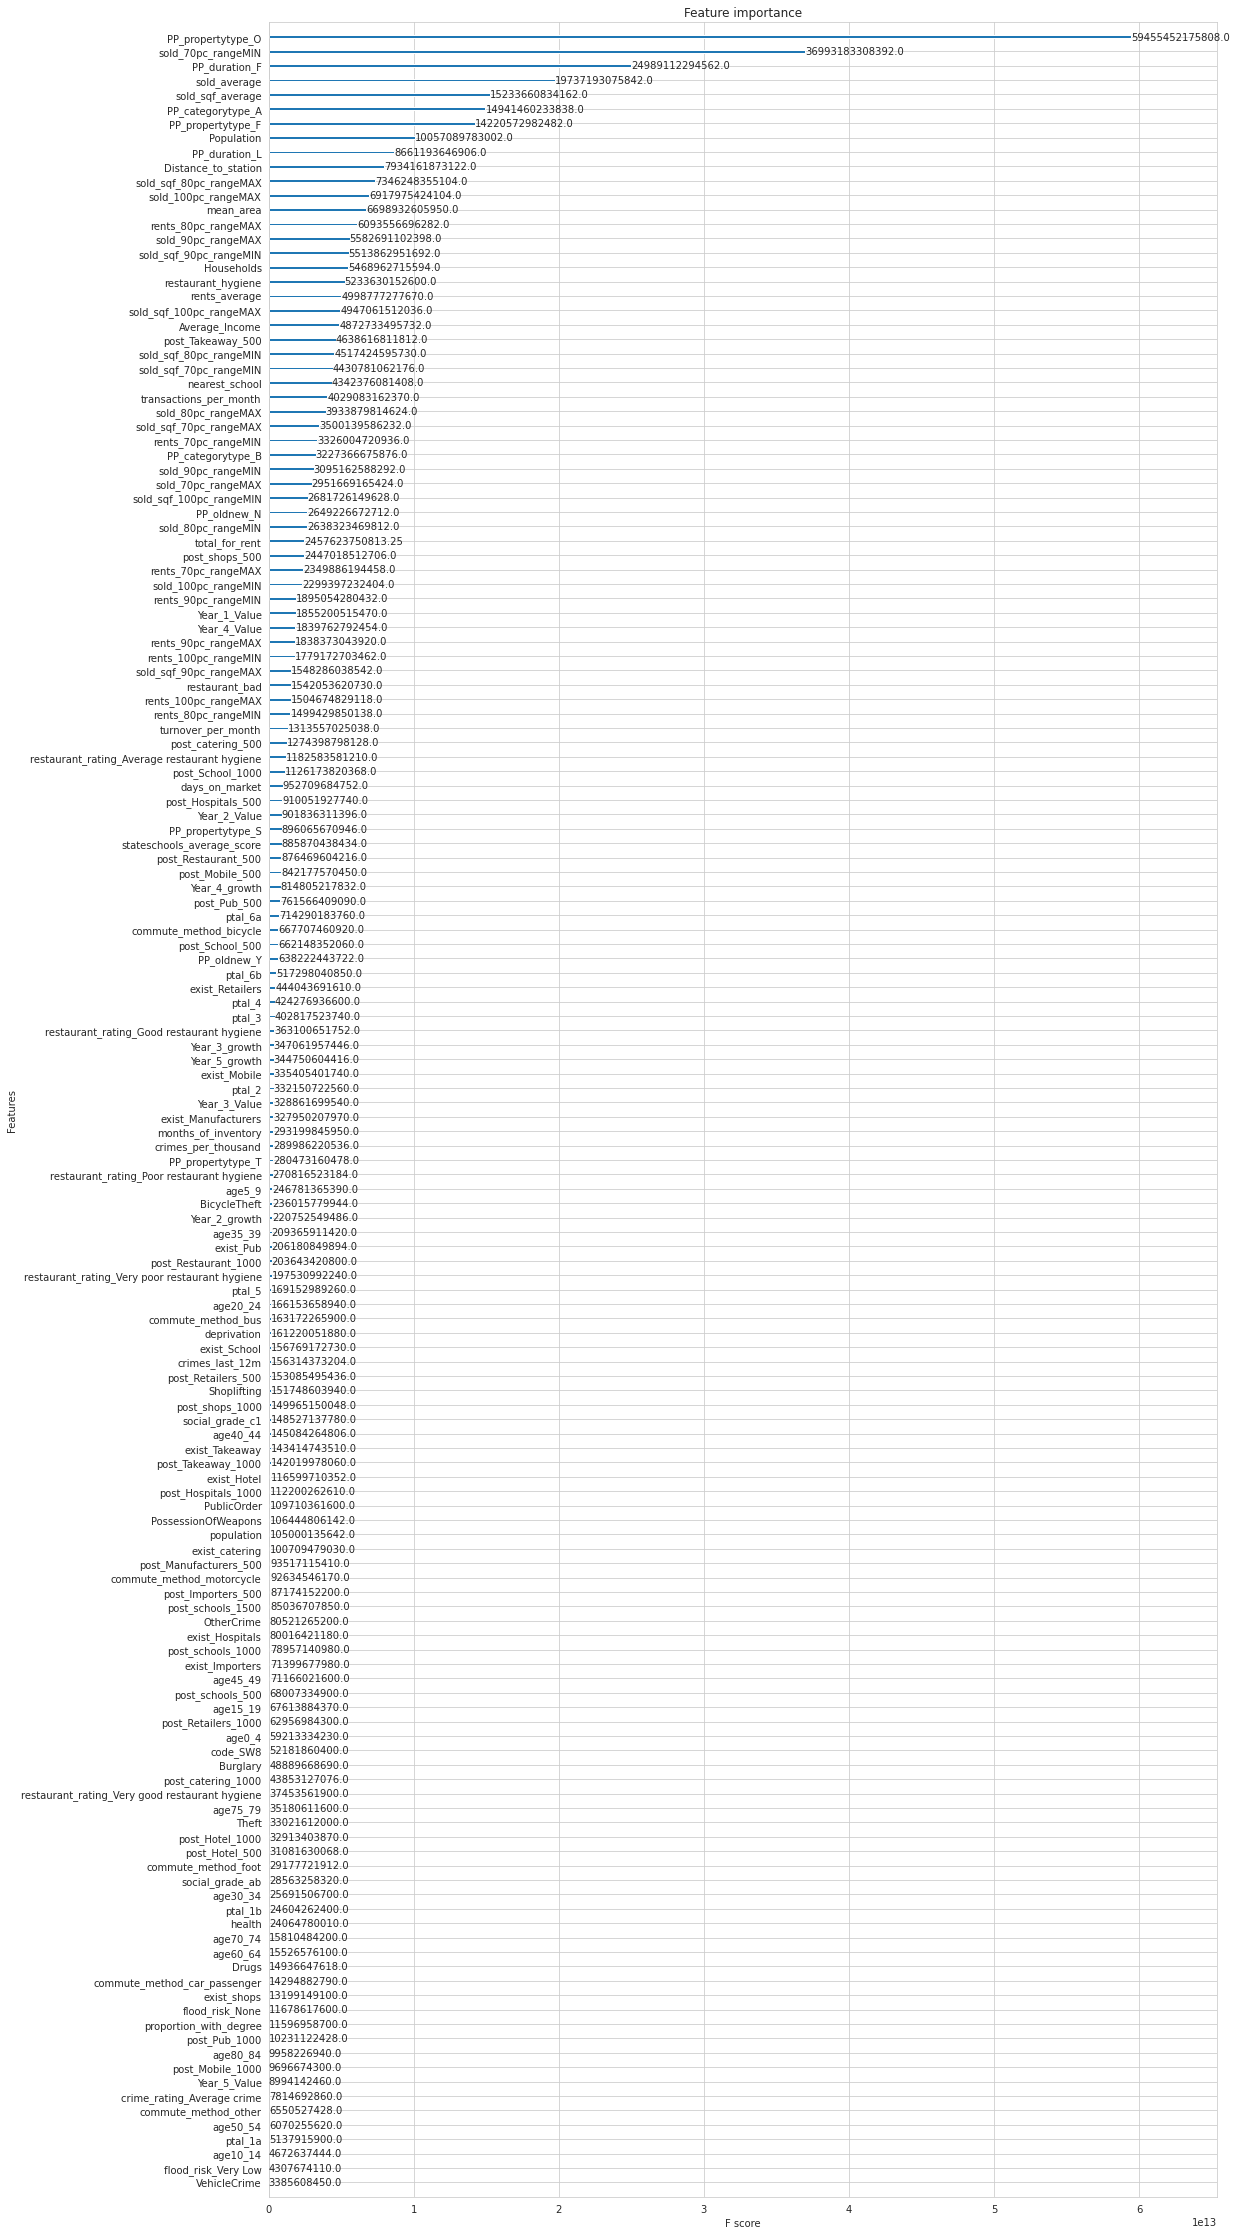

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(17,40))

xg.plot_importance(xgb_r, ax,importance_type='total_gain')

#### Ranking by total cover (uses the total loss)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

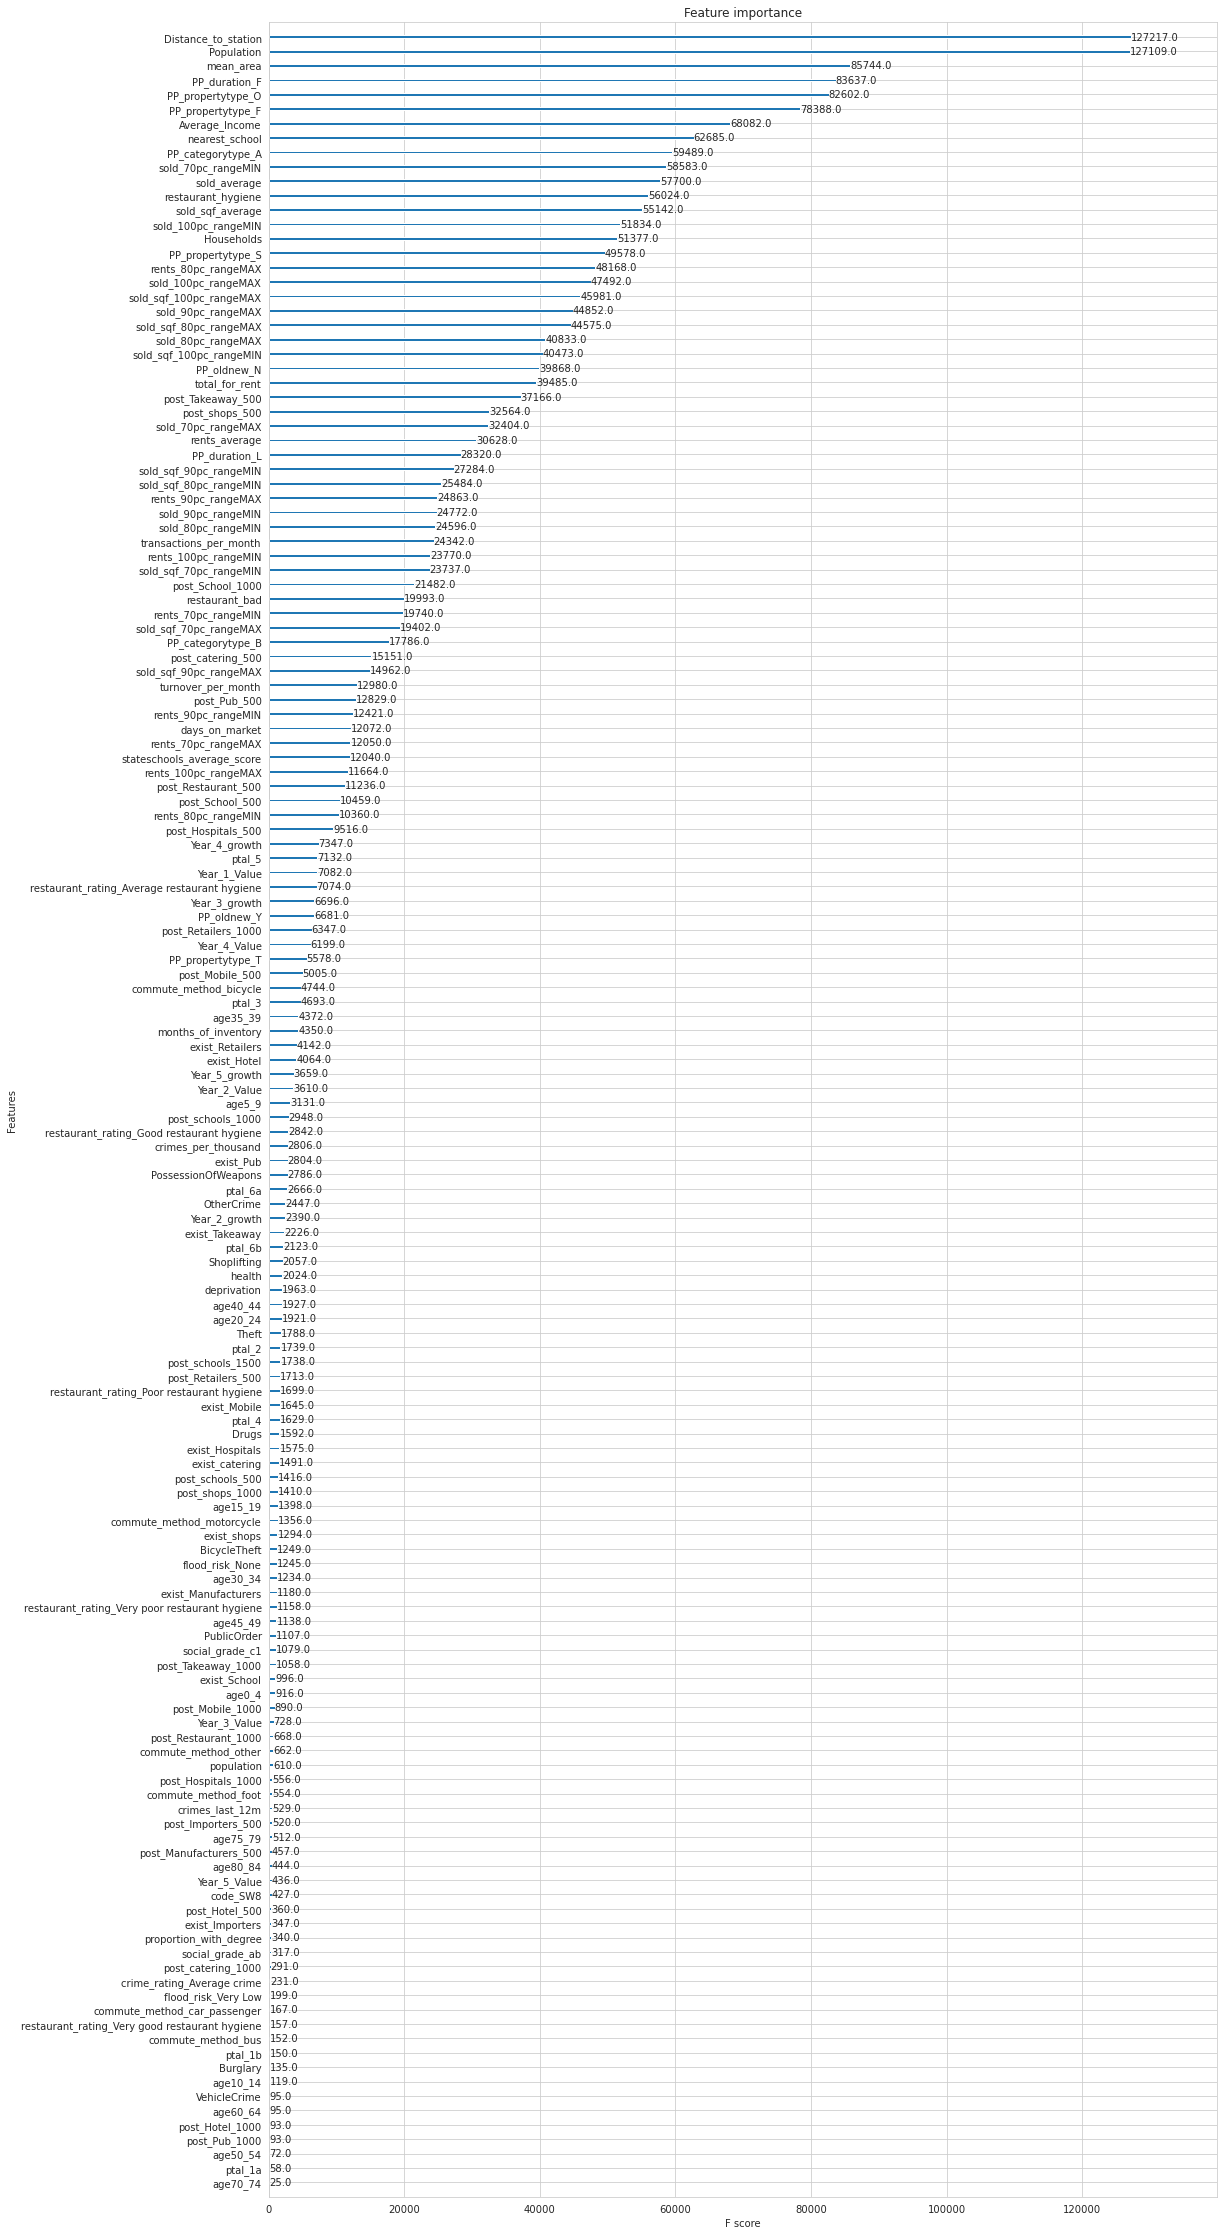

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(17,40))

xg.plot_importance(xgb_r, ax,importance_type='total_cover')

#### Ranking by weight

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

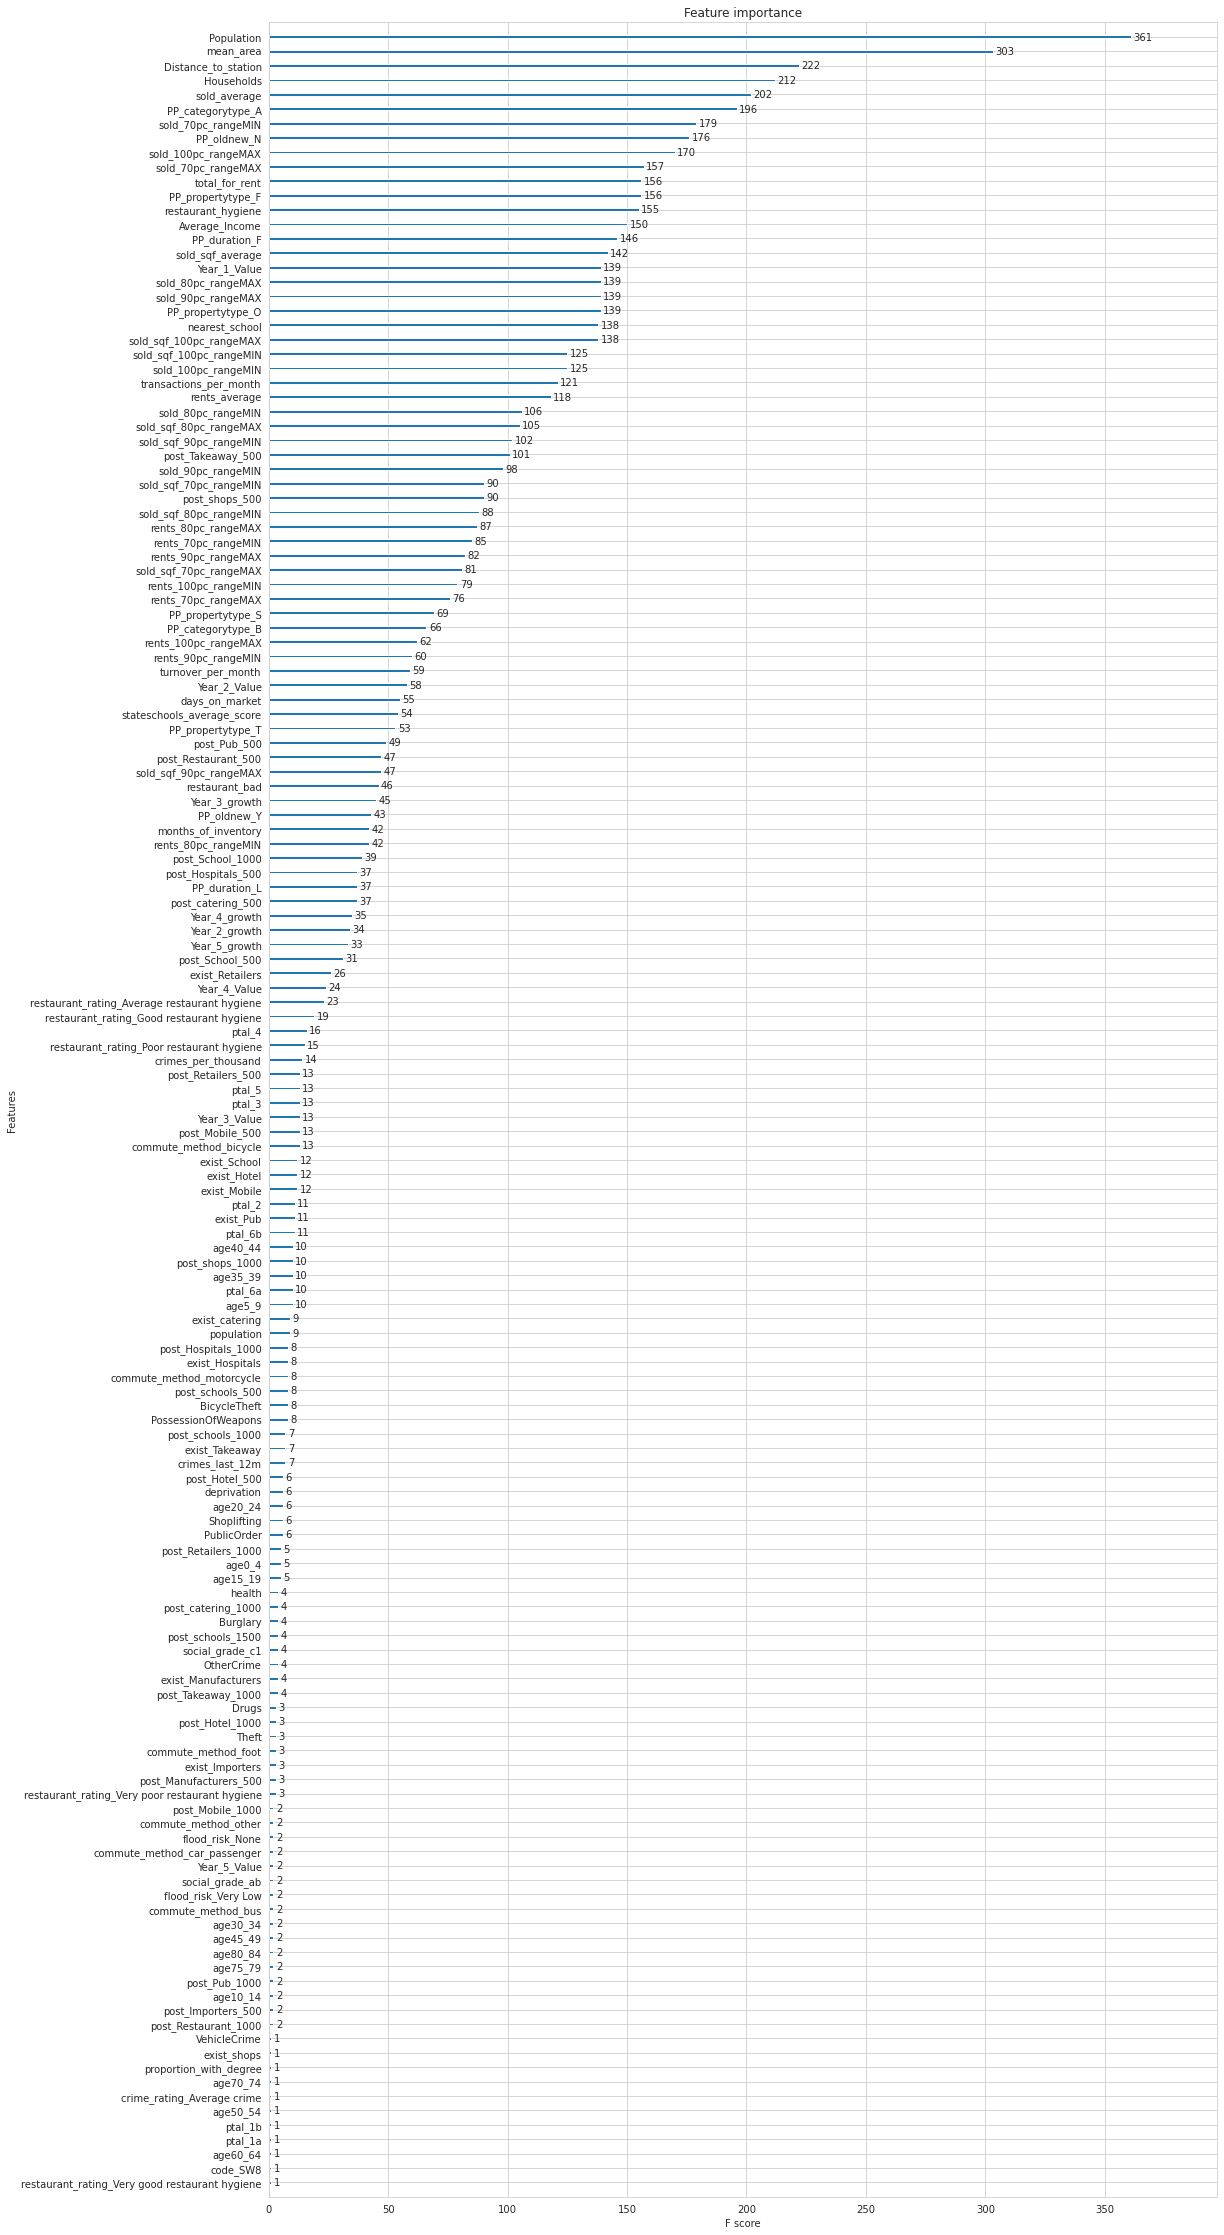

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(17,40))

xg.plot_importance(xgb_r, ax,importance_type='weight')

##Total price vs error

/home/carlos/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1181: UserWarning: The following kwargs were not used by contour: 'row'
  cset = contour_func(
No handles with labels found to put in legend.


Text(0.5, 32.99999999999995, 'real price')

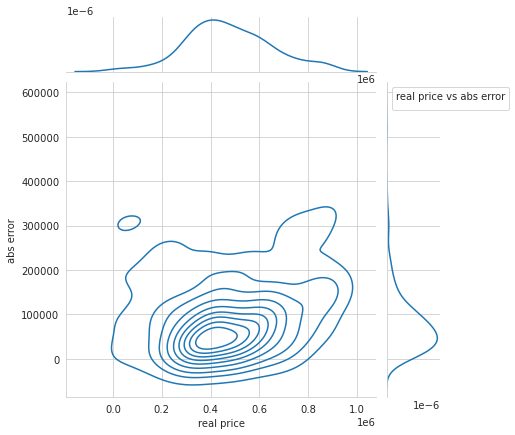

In [ ]:
h=sns.jointplot(x = test_y, y = np.abs(test_y-pred), kind ='kde', row="day")
plt.legend(title='real price vs abs error')
h.ax_joint.set_ylabel('abs error')
h.ax_joint.set_xlabel('real price')

Error distribution

No handles with labels found to put in legend.


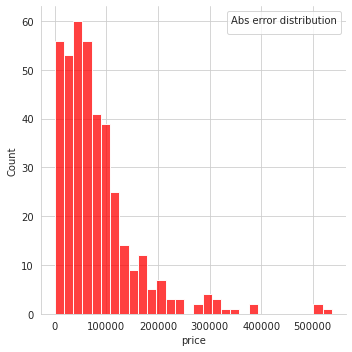

In [ ]:
sns.set_style('whitegrid')
h=sns.displot(np.abs(test_y-pred), kde = False, color ='red', bins = 30)
plt.legend(title='Abs error distribution')